In [1]:
% matplotlib inline
import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from scipy.misc import logsumexp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.linalg import kron
from fastkml import kml, styles
from shapely.geometry import Point, LineString
import pulp

In [2]:
RANK_C = 10  # regularisation parameter for rankSVM
BIN_CLUSTER = 5  # Number of bins/clusters for discritizing POI features
ranksvm_dir = '$HOME/work/ranksvm'
data_dir = '../data'
fpoi = os.path.join(data_dir, 'poi-Melb-all.csv')
fvisits = os.path.join(data_dir, 'userVisits-Melb.csv')
fphotos = os.path.join(data_dir, 'Melb_photos_bigbox.csv')

In [4]:
# 1. Load Data

#Load POI Data

poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
#poi_all.head()

In [5]:
poi_df = poi_all.copy()
poi_df.drop('poiURL', axis=1, inplace=True)
poi_df.rename(columns={'poiName':'Name', 'poiTheme':'Category', 'poiLat':'Latitude', 'poiLon':'Longitude'}, \
              inplace=True)
poi_df.head()

,Name,Category,Latitude,Longitude
poiID,,,,
0,Arts Precinct,City precincts,-37.82167,144.96778
1,Docklands,City precincts,-37.81700,144.94600
2,Government Precinct,City precincts,-37.81190,144.97300
3,Little Italy,City precincts,-37.79972,144.96694
4,RMIT City,City precincts,-37.80778,144.96333


In [6]:
#Load Trajectory Data

visits = pd.read_csv(fvisits, sep=';')
#visits.head()

In [7]:
visits.drop(['poiTheme', 'poiFreq'], axis=1, inplace=True)
visits.rename(columns={'seqID':'trajID'}, inplace=True)
visits.head()

,photoID,userID,dateTaken,poiID,trajID
0,3233170275,34823318@N06,949323600,30,1370
1,2104214833,49503207397@N01,1006801914,40,2340
2,2104993710,49503207397@N01,1006803152,71,2340
3,2104215119,49503207397@N01,1006803177,71,2340
4,2104994064,49503207397@N01,1006803611,71,2340


In [8]:
# 2. Compute POI Statistics DataFrame

#Compute POI visit statistics: 

#the number of photos associated with each POI:
poi_photo = visits[['photoID', 'poiID']].copy().groupby('poiID').agg(np.size)
poi_photo.rename(columns={'photoID':'#photos'}, inplace=True)
poi_photo.head()

,#photos
poiID,
0,102
1,139
2,304
3,138
4,349


In [9]:
#the visit duration at each POI:
poi_duration = visits[['dateTaken', 'poiID', 'trajID']].copy().groupby(['trajID', 'poiID']).agg([np.min, np.max])
poi_duration.columns = poi_duration.columns.droplevel()
poi_duration.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
poi_duration.reset_index(inplace=True)
poi_duration['poiDuration'] = poi_duration['departureTime'] - poi_duration['arrivalTime']
poi_duration.head()

,trajID,poiID,arrivalTime,departureTime,poiDuration
0,0,25,1226726126,1226726126,0
1,1,58,1205332532,1205332541,9
2,1,66,1205342722,1205342729,7
3,2,59,1205374109,1205374109,0
4,3,58,1205417265,1205417265,0


In [10]:
#filtering out zero visit duration at POI
poi_duration = poi_duration[poi_duration['poiDuration'] > 0]

In [11]:
#the median and summation of POI visit duration=
poi_duration_stats = poi_duration[['poiID', 'poiDuration']].copy().groupby('poiID').agg([np.median, np.sum])
poi_duration_stats.columns = poi_duration_stats.columns.droplevel()
poi_duration_stats.rename(columns={'median':'medianDuration(sec)', 'sum':'totalDuration(sec)'}, inplace=True)
poi_duration_stats.head()

,medianDuration(sec),totalDuration(sec)
poiID,,
0,332.5,24600
1,438.5,42491
2,1835.0,141155
3,1971.5,61945
4,829.0,137382


In [12]:
#the number of visits at each POI by all users and by distinct users:  

poi_visits = visits[['userID', 'trajID', 'poiID', 'photoID']].copy().groupby(['userID','trajID','poiID']).agg(np.size)
poi_visits.reset_index(inplace=True)
poi_visits.rename(columns={'photoID':'#photosAtPOIInTraj'}, inplace=True)
poi_visits.head()

,userID,trajID,poiID,#photosAtPOIInTraj
0,10058801@N06,0,25,1
1,10087938@N02,1,58,2
2,10087938@N02,1,66,2
3,10087938@N02,2,59,1
4,10087938@N02,3,58,1


In [13]:
poi_visits_stats = poi_visits[['userID', 'poiID']].copy().groupby('poiID').agg([pd.Series.nunique, np.size])
poi_visits_stats.columns = poi_visits_stats.columns.droplevel()
poi_visits_stats.rename(columns={'nunique':'#distinctUsers', 'size':'#visits'}, inplace=True)
poi_visits_stats.head()

,#distinctUsers,#visits
poiID,,
0,64,73
1,39,52
2,83,116
3,44,54
4,50,84


In [14]:
#copy visit statistics to POI dataframe:
poi_df['#photos'] = 0
poi_df['#visits'] = 0
poi_df['#distinctUsers'] = 0
poi_df['medianDuration(sec)'] = 0.0
poi_df['totalDuration(sec)'] = 0.0

In [15]:
poi_df.loc[poi_photo.index, '#photos'] = poi_photo['#photos']
poi_df.loc[poi_visits_stats.index, '#visits'] = poi_visits_stats['#visits']
poi_df.loc[poi_visits_stats.index, '#distinctUsers'] = poi_visits_stats['#distinctUsers']
poi_df.loc[poi_duration_stats.index, 'medianDuration(sec)'] = poi_duration_stats['medianDuration(sec)']
poi_df.loc[poi_duration_stats.index, 'totalDuration(sec)'] = poi_duration_stats['totalDuration(sec)']
poi_df.head()

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
0,Arts Precinct,City precincts,-37.82167,144.96778,102,73,64,332.5,24600.0
1,Docklands,City precincts,-37.81700,144.94600,139,52,39,438.5,42491.0
2,Government Precinct,City precincts,-37.81190,144.97300,304,116,83,1835.0,141155.0
3,Little Italy,City precincts,-37.79972,144.96694,138,54,44,1971.5,61945.0
4,RMIT City,City precincts,-37.80778,144.96333,349,84,50,829.0,137382.0


In [16]:
#visualise & save POIs to CSV file
#poi_file = os.path.join(data_dir, 'poi_df.csv')
#poi_df.to_csv(poi_file, index=True)

In [17]:
# 3. POI vs Photo

#POIs with NO Visits


poi_df[poi_df['#visits'] < 1]

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
54,Flemington Racecourse,Sports stadiums,-37.79028,144.91250,0,0,0,0.0,0.0
64,Royal Melbourne Golf Club,Sports stadiums,-37.97000,145.03000,0,0,0,0.0,0.0
87,Yarra River,Transport,-37.85194,144.90833,0,0,0,0.0,0.0


In [18]:
# 4. Compute Trajectories

#compute trajectories using POI visiting records, assuming NO loops/subtours in trajectories

traj_all = visits[['userID', 'trajID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'trajID', 'poiID'])\
           .agg([np.min, np.max, np.size])
traj_all.columns = traj_all.columns.droplevel()
traj_all.reset_index(inplace=True)
traj_all.rename(columns={'amin':'startTime', 'amax':'endTime', 'size':'#photo'}, inplace=True)

In [19]:
traj_len = traj_all[['userID', 'trajID', 'poiID']].copy().groupby(['userID', 'trajID']).agg(np.size)
traj_len.reset_index(inplace=True)
traj_len.rename(columns={'poiID':'trajLen'}, inplace=True)

In [20]:
traj_all = pd.merge(traj_all, traj_len, on=['userID', 'trajID'])
traj_all['poiDuration'] = traj_all['endTime'] - traj_all['startTime']
traj_all.head(10)

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10058801@N06,0,25,1226726126,1226726126,1,1,0
1,10087938@N02,1,58,1205332532,1205332541,2,2,9
2,10087938@N02,1,66,1205342722,1205342729,2,2,7
3,10087938@N02,2,59,1205374109,1205374109,1,1,0
4,10087938@N02,3,58,1205417265,1205417265,1,1,0
5,10087938@N02,4,58,1205508764,1205538412,3,2,29648
6,10087938@N02,4,59,1205512653,1205514882,22,2,2229
7,10087938@N02,5,59,1205575764,1205595114,4,1,19350
8,10087938@N02,6,59,1205625724,1205641382,2,1,15658
9,10087938@N02,7,58,1205812892,1205812892,1,1,0


In [21]:
#extract trajectory, i.e., a list of POIs, considering loops/subtours:

def extract_traj_withloop(tid, visits):
    """Compute trajectories info, taking care of trajectories that contain sub-tours"""
    traj_df = visits[visits['trajID'] == tid].copy()
    traj_df.sort_values(by='dateTaken', ascending=True, inplace=True)
    traj = []
    for ix in traj_df.index:
        poi = traj_df.loc[ix, 'poiID']
        if len(traj) == 0:
            traj.append(poi)
        else:
            if poi != traj[-1]:
                traj.append(poi)
    return traj

In [22]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

In [23]:
loopcnt = 0
for tid_ in visits['trajID'].unique():
    traj_ = extract_traj_withloop(tid_, visits)
    if len(traj_) != len(set(traj_)):
        #print(traj_)
        loopcnt += 1
print('Number of trajectories with loops/subtours:', loopcnt)

Number of trajectories with loops/subtours: 211


In [24]:
#Compute POI properties, e.g., popularity, total number of visit, average visit duration.

def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

In [25]:
#compute the F1 score for recommended trajectory

def calc_F1(traj_act, traj_rec):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    intersize = len(set(traj_act) & set(traj_rec))
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

In [26]:
#compute distance between two POIs using the Haversine formula

def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

In [27]:
#distance between POIs:

POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [28]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [29]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [30]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

In [31]:
poi_info_all.head()

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
0,336.986301,73,City precincts,144.96778,-37.82167,64
1,817.134615,52,City precincts,144.94600,-37.81700,39
2,1216.853448,116,City precincts,144.97300,-37.81190,83
3,1147.129630,54,City precincts,144.96694,-37.79972,44
4,1635.500000,84,City precincts,144.96333,-37.80778,50


In [32]:
#dump POI popularity.

poi_all['poiPopularity'] = 0
poi_all.loc[poi_info_all.index, 'poiPopularity'] = poi_info_all.loc[poi_info_all.index, 'popularity']
poi_all.head()

,poiName,poiTheme,poiLat,poiLon,poiURL,poiPopularity
poiID,,,,,,
0,Arts Precinct,City precincts,-37.82167,144.96778,https://en.wikipedia.org/wiki/Melbourne_Arts_P...,64
1,Docklands,City precincts,-37.81700,144.94600,"https://en.wikipedia.org/wiki/Docklands,_Victoria",39
2,Government Precinct,City precincts,-37.81190,144.97300,"https://en.wikipedia.org/wiki/Spring_Street,_M...",83
3,Little Italy,City precincts,-37.79972,144.96694,"https://en.wikipedia.org/wiki/Little_Italy,_Me...",44
4,RMIT City,City precincts,-37.80778,144.96333,https://en.wikipedia.org/wiki/City_campus_of_t...,50


In [32]:
#poi_all.to_csv('poi_all.csv', index=True)
#zero_duration = poi_info_all[poi_info_all['avgDuration'] < 1]
#zero_duration
#print(traj_all.shape)
#traj_all = traj_all[traj_all['poiID'].isin(set(poi_info_all.index) - set(zero_duration.index))]
#print(traj_all.shape)

In [34]:
#dictionary to map every trajectory ID to the actual trajectory.

traj_dict = dict()
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

In [35]:
#query defined using tuple (start POI, end POI, #POI)

QUERY_ID_DICT = dict()  # (start, end, length) --> qid

In [36]:
keys = [(traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 2]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, end, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [37]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 5106
#traj (length > 2): 442
#query tuple: 415


In [38]:
# 5. Recommendation via POI Ranking


#features used for ranking:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration', \
              'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'trajLen', 'diffPopStart', \
              'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd']

In [39]:
#generating training dataFrame
def gen_train_subdf(poi_id, query_id_set, poi_info, query_id_rdict):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(data=np.zeros((len(query_id_set), len(columns)), dtype=np.float), columns=columns)
    
    pop = poi_info.loc[poi_id, 'popularity']; nvisit = poi_info.loc[poi_id, 'nVisit']
    cat = poi_info.loc[poi_id, 'poiCat']; duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        
    return df_

In [40]:
def gen_train_df(trajid_list, traj_dict, poi_info, n_jobs=-1):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) > 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, query_id_rdict) \
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for t in train_trajs:
        qid = query_id_dict[(t[0], t[-1], len(t))]
        for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

In [41]:
#generating test dataframe
def gen_test_df(startPOI, endPOI, nPOI, poi_info):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    df_ = pd.DataFrame(data=np.zeros((poi_info.shape[0], len(columns)), dtype= np.float), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiCat']; duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
    return df_

In [42]:
#generate a string for a training/test data frame.
def gen_data_str(df_, df_columns=DF_COLUMNS):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

In [43]:
#ranking POIs using rankSVM
#use softmax function to convert ranking scores to a probability distribution
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

In [44]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
        
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        #poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

In [45]:
# 6. Factorised Transition Probabilities

# POI features for factorisation

#POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
#Category of POI
#Popularity of POI (discritize with uniform log-scale bins, #bins=5 )
#The number of POI visits (discritize with uniform log-scale bins, #bins=5 )
#The average visit duration of POI (discritise with uniform log-scale bins, #bins= 5)
#The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters= 5)

#counting the number of transition first, then normalising each row while taking care of zero by adding each cell a number

def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

In [46]:
#POIs in training set
poi_train = sorted(poi_info_all.index)

In [47]:
# transition matrix between POI Categories

poi_cats = poi_all.loc[poi_train, 'poiTheme'].unique().tolist()
poi_cats.sort()
#poi_cats

In [48]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=poi_cats):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [49]:
gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

,City precincts,Entertainment,Institutions,Parks and spaces,Public galleries,Shopping,Sports stadiums,Structures,Transport
City precincts,0.059259,0.059259,0.207407,0.118519,0.096296,0.148148,0.059259,0.148148,0.103704
Entertainment,0.043011,0.107527,0.086022,0.086022,0.043011,0.193548,0.021505,0.225806,0.193548
Institutions,0.063830,0.031915,0.188830,0.188830,0.015957,0.265957,0.013298,0.138298,0.093085
Parks and spaces,0.041322,0.030303,0.154270,0.151515,0.033058,0.126722,0.049587,0.236915,0.176309
Public galleries,0.114286,0.071429,0.128571,0.142857,0.057143,0.142857,0.028571,0.114286,0.200000
Shopping,0.057377,0.049180,0.229508,0.077869,0.010246,0.354508,0.008197,0.086066,0.127049
Sports stadiums,0.059524,0.107143,0.059524,0.202381,0.023810,0.071429,0.321429,0.047619,0.107143
Structures,0.053968,0.076190,0.107937,0.247619,0.028571,0.171429,0.025397,0.136508,0.152381
Transport,0.067340,0.043771,0.151515,0.185185,0.013468,0.185185,0.030303,0.202020,0.121212


In [50]:
# transition matrix between POI Popularity Classes
poi_pops = poi_info_all.loc[poi_train, 'popularity']
#sorted(poi_pops.unique().tolist())

In [51]:
#discretizing POI popularity with uniform log-scale bins
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.4623979979


In [52]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

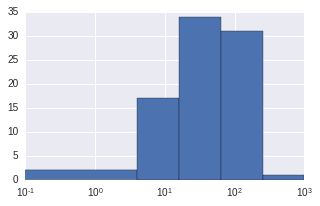

In [53]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [54]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [55]:
gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.166667,0.166667,0.333333,0.166667,0.166667
2,0.017544,0.175439,0.350877,0.421053,0.035088
3,0.002262,0.033937,0.316742,0.608597,0.038462
4,0.001350,0.025641,0.172065,0.715250,0.085695
5,0.005618,0.022472,0.095506,0.870787,0.005618


In [56]:
# transition matrix between the Number of POI Visit Classes

poi_visits = poi_info_all.loc[poi_train, 'nVisit']
#sorted(poi_visits.unique().tolist())

In [57]:
#discretizing the number of POI visit with uniform log-scale bins
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.69108149212


In [58]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

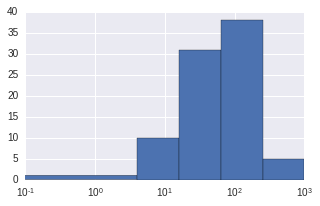

In [59]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [60]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [61]:
gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.038462,0.076923,0.346154,0.500000,0.038462
3,0.003448,0.027586,0.272414,0.562069,0.134483
4,0.000762,0.017517,0.121097,0.614623,0.246002
5,0.001883,0.007533,0.064030,0.651601,0.274953


In [62]:
# transition matrix between POI Average Visit Duration Classes
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']
#sorted(poi_durations.unique().tolist())

In [63]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.90794220593


In [64]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([  0.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   8.08988235e+05])

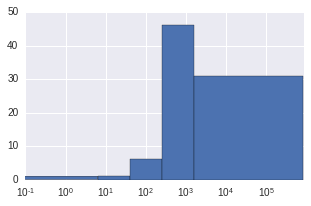

In [65]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [66]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [67]:
gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.166667,0.166667,0.166667,0.333333,0.166667
3,0.012658,0.012658,0.037975,0.582278,0.354430
4,0.000708,0.001416,0.043201,0.647309,0.307365
5,0.001508,0.001508,0.036199,0.686275,0.274510


In [68]:
# transition matrix between POI Neighborhood Classes

#using Euclidean distance to approximate
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [69]:
kmeans = KMeans(n_clusters=nclusters, random_state=987654321)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=987654321,
    tol=0.0001, verbose=0)

In [70]:
clusters = kmeans.predict(X)
#clusters
poi_clusters = pd.DataFrame(data=clusters, index=poi_train)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

In [71]:
poi_clusters.to_csv('cluster.1.csv')

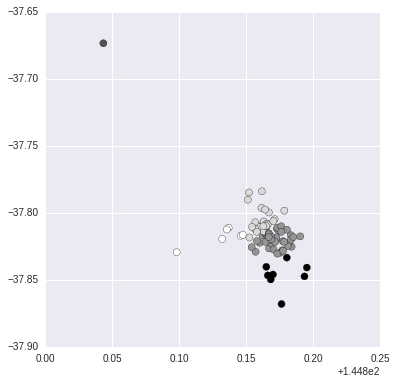

In [72]:
#scatter plot of POI coordinates with clustering results.
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
#ratio
height = 6; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [73]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=poi_clusters):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [74]:
gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

,0,1,2,3,4
0,0.200000,0.250000,0.500000,0.025000,0.025000
1,0.034351,0.500000,0.442748,0.001908,0.020992
2,0.007083,0.134578,0.840953,0.000644,0.016742
3,0.200000,0.200000,0.200000,0.200000,0.200000
4,0.023256,0.162791,0.581395,0.023256,0.209302


In [75]:
# transition matrix between POIs

def gen_poi_transmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    poi_transmat = np.power(10, poi_logtransmat)
    return poi_transmat

In [76]:
poi_transmat = gen_poi_transmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=False)

In [106]:
#7. recommendation results comparison & visualisation

#trajectory of length 4
traj4s = traj_all[traj_all['trajLen'] == 4]['trajID'].unique()
traj4s

array([  64,  147,  150,  198,  311,  385,  445,  680,  720,  725,  765,
        771,  785,  835,  841,  902,  966, 1042, 1087, 1119, 1134, 1150,
       1170, 1208, 1217, 1233, 1241, 1245, 1265, 1277, 1315, 1562, 1593,
       1769, 1906, 1914, 1921, 1923, 1936, 1984, 1990, 2042, 2101, 2144,
       2220, 2240, 2301, 2340, 2354, 2430, 2572, 2646, 2672, 2690, 2826,
       2912, 3004, 3017, 3091, 3271, 3408, 3505, 3659, 3745, 3775, 3811,
       3888, 3891, 4124, 4130, 4133, 4160, 4183, 4198, 4202, 4204, 4205,
       4245, 4316, 4368, 4372, 4376, 4396, 4440, 4450, 4702, 4710, 4742,
       4832, 4842, 4887, 4906, 4922, 5064, 5067])

In [107]:
#for tid in traj4s:
#    gen_kml(tid, traj_all, poi_df)

In [108]:
tid = 680
traj = extract_traj(tid, traj_all)
print('REAL:', traj)

REAL: [76, 81, 71, 68]


In [109]:
traj_dict_rec = {'REAL_' + str(tid): traj}

In [110]:
start = traj[0]
end = traj[-1]
length = len(traj)

In [111]:
#recommend trajectory based on POI popularity
poi_df.sort_values(by='#distinctUsers', ascending=False, inplace=True)
rec_pop = [start] + [x for x in poi_df.index.tolist() if x not in {start, end}][:length-2] + [end]
print('REC_POP:', rec_pop)

REC_POP: [76, 71, 82, 68]


In [112]:
tid_rec = 'REC_POP'
traj_dict_rec[tid_rec] = rec_pop

In [113]:
#recommend trajectory based on the ranking of POIs using rankSVM
trajid_list_train = list(set(trajid_set_all) - {tid})
poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)

In [114]:
train_df = gen_train_df(trajid_list_train, traj_dict, poi_info) # POI feature based ranking
ranksvm = RankSVM(ranksvm_dir, useLinear=True)
ranksvm.train(train_df, cost=RANK_C)
test_df = gen_test_df(start, end, length, poi_info)
rank_df = ranksvm.predict(test_df)
rank_df.sort_values(by='rank', ascending=False, inplace=True)
rec_rank = [start] + [x for x in rank_df.index.tolist() if x not in {start, end}][:length-2] + [end]
print('REC_RANK:', rec_rank)

REC_RANK: [76, 71, 82, 68]


In [115]:
tid_rec = 'REC_RANK'
traj_dict_rec[tid_rec] = rec_rank

In [116]:
#recommendation by Transition Probabilities

#dynamic programming to find a path
def find_path(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    # with sub-tours in trajectory, this is not the case any more, but it is nonsense to recommend such trajectories
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:
        if v != ps:
            if withNodeWeight == True:
                A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            else:
                A.loc[2, v] = E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withNodeWeight == True: # ps-~-v1---v
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else:
                values = [A.loc[l-1, v1] + E.loc[v1, v] for v1 in V.index]  # ps-~-v1---v   
            
            minix = np.argmin(values)
            A.loc[l, v] = values[minix]
            B.loc[l, v] = V.index[minix]
            
    path = [pe]
    v = path[-1]
    l = L
    #while v != ps:  #incorrect if 'ps' happens to appear in the middle of a path
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

In [117]:
#integer linear programming (ILP) to find a simple path
def find_path_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # deal with np.inf which will cause ILP solver failure
    Edges = E.copy()
    INF = 1e6
    for p in Edges.index:
        Edges.loc[p, p] = INF 
    maxL = np.max(Edges.values.flatten())
    if maxL > INF:
        for p in Edges.index:
            Edges.loc[p, p] = maxL    
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMinimize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha*V.loc[int(pj), 'weight'] + beta*Edges.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * Edges.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #gurobi_options = [('TimeLimit', '7200'), ('Threads', '8'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    #pb.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

In [118]:
poi_logtransmat = np.log(gen_poi_transmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info))
nodes = poi_info.copy()
edges = poi_logtransmat.copy()
edges = -1 * edges  # edge weight is negative log of transition probability
rec_dp = find_path(nodes, edges, start, end, length) # DP
rec_ilp = find_path_ILP(nodes, edges, start, end, length) # ILP
print('REC_DP:', rec_dp)
print('REC_ILP:', rec_ilp)

REC_DP: [76, 81, 70, 68]
REC_ILP: [76, 81, 70, 68]


In [119]:
tid_rec = 'REC_DP'
traj_dict_rec[tid_rec] = rec_dp
tid_rec = 'REC_ILP'
traj_dict_rec[tid_rec] = rec_ilp

In [120]:
traj_dict_rec

{'REAL_680': [76, 81, 71, 68],
 'REC_DP': [76, 81, 70, 68],
 'REC_ILP': [76, 81, 70, 68],
 'REC_POP': [76, 71, 82, 68],
 'REC_RANK': [76, 71, 82, 68]}